In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

base_dir = 'data'

df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))


lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x 
                     for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

df['path'] = df['image_id'].map(imageid_path_dict.get)
df.head(5)

/Users/shalu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,data/reshaped/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,data/reshaped/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,data/reshaped/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,data/reshaped/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,data/reshaped/ISIC_0031633.jpg


In [2]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
cell_type         0
cell_type_idx     0
path              0
dtype: int64

In [3]:
df[1500:1550]

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
1500,HAM_0001266,ISIC_0029909,mel,histo,75.0,female,ear,Melanoma,5,data/reshaped/ISIC_0029909.jpg
1501,HAM_0005893,ISIC_0033432,mel,histo,55.0,male,trunk,Melanoma,5,data/reshaped/ISIC_0033432.jpg
1502,HAM_0005893,ISIC_0032833,mel,histo,55.0,male,trunk,Melanoma,5,data/reshaped/ISIC_0032833.jpg
1503,HAM_0005893,ISIC_0034236,mel,histo,55.0,male,trunk,Melanoma,5,data/reshaped/ISIC_0034236.jpg
1504,HAM_0001174,ISIC_0033027,mel,histo,70.0,male,scalp,Melanoma,5,data/reshaped/ISIC_0033027.jpg
1505,HAM_0002824,ISIC_0034118,mel,histo,25.0,female,lower extremity,Melanoma,5,data/reshaped/ISIC_0034118.jpg
1506,HAM_0002824,ISIC_0033476,mel,histo,25.0,female,lower extremity,Melanoma,5,data/reshaped/ISIC_0033476.jpg
1507,HAM_0002824,ISIC_0033047,mel,histo,25.0,female,lower extremity,Melanoma,5,data/reshaped/ISIC_0033047.jpg
1508,HAM_0002824,ISIC_0025987,mel,histo,25.0,female,lower extremity,Melanoma,5,data/reshaped/ISIC_0025987.jpg
1509,HAM_0007368,ISIC_0032017,mel,histo,70.0,male,face,Melanoma,5,data/reshaped/ISIC_0032017.jpg


In [4]:
df['age'].fillna((df['age'].mean()), inplace=True)
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
cell_type        0
cell_type_idx    0
path             0
dtype: int64

In [5]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,data/reshaped/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,data/reshaped/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,data/reshaped/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,data/reshaped/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,data/reshaped/ISIC_0031633.jpg


In [6]:
print(df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
cell_type         object
cell_type_idx       int8
path              object
dtype: object


In [7]:

'''for i in range(df.shape[0]):
    path = df['path'][i]
    print(path)
    df['image'][i] = np.asarray(Image.open(path))
    print(df['image'][i])'''



df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x)))
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,data/reshaped/ISIC_0027419.jpg,"[[[190, 155, 188], [190, 155, 188], [190, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,data/reshaped/ISIC_0025030.jpg,"[[[22, 15, 33], [20, 11, 30], [25, 13, 33], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,data/reshaped/ISIC_0026769.jpg,"[[[175, 127, 141], [181, 131, 143], [192, 138,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,data/reshaped/ISIC_0025661.jpg,"[[[29, 9, 18], [28, 9, 15], [44, 21, 27], [56,..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,data/reshaped/ISIC_0031633.jpg,"[[[133, 87, 113], [151, 103, 129], [163, 115, ..."


In [8]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [9]:
df_nv = df[df.dx=='nv']
df_mel = df[df.dx=='mel']
df_bkl = df[df.dx=='bkl']
df_bcc = df[df.dx=='bcc']
df_akiec = df[df.dx=='akiec']
df_vasc = df[df.dx=='vasc']
df_df = df[df.dx=='df']
df_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
1095,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,Dermatofibroma,3,data/reshaped/ISIC_0027008.jpg,"[[[155, 110, 105], [166, 121, 116], [178, 133,..."
1096,HAM_0005276,ISIC_0028790,df,histo,75.0,male,back,Dermatofibroma,3,data/reshaped/ISIC_0028790.jpg,"[[[205, 159, 169], [212, 167, 174], [217, 170,..."
1097,HAM_0004103,ISIC_0028880,df,histo,55.0,male,lower extremity,Dermatofibroma,3,data/reshaped/ISIC_0028880.jpg,"[[[221, 187, 212], [223, 189, 214], [223, 190,..."
1098,HAM_0004103,ISIC_0031309,df,histo,55.0,male,lower extremity,Dermatofibroma,3,data/reshaped/ISIC_0031309.jpg,"[[[30, 14, 25], [46, 28, 40], [63, 45, 57], [8..."
1099,HAM_0001164,ISIC_0030021,df,histo,50.0,female,upper extremity,Dermatofibroma,3,data/reshaped/ISIC_0030021.jpg,"[[[198, 155, 162], [198, 155, 162], [198, 155,..."


In [10]:
from sklearn.utils import resample

df_df_upsample = resample(df_df, 
                                 replace=True,     
                                 n_samples=1000,    
                                 random_state=123)
df_nv_downsample = resample(df_nv, 
                                 replace=True,     
                                 n_samples=1000,    
                                 random_state=123)
df_mel_upsample = resample(df_mel, 
                                 replace=True,     
                                 n_samples=1000,    
                                 random_state=123)
df_bkl_upsample = resample(df_bkl, 
                                 replace=True,     
                                 n_samples=1000,    
                                 random_state=123)
df_bcc_upsample = resample(df_bcc, 
                                 replace=True,     
                                 n_samples=1000,    
                                 random_state=123)
df_akiec_upsample = resample(df_akiec, 
                                 replace=True,     
                                 n_samples=1000,    
                                 random_state=123)
df_vasc_upsample = resample(df_vasc, 
                                 replace=True,     
                                 n_samples=1000,    
                                 random_state=123)



In [11]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'cell_type', 'cell_type_idx', 'path', 'image'],
      dtype='object')

In [12]:
df_resampled = pd.DataFrame(columns=['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'cell_type', 'cell_type_idx', 'path', 'image'],
      dtype='object')

In [13]:
df_resampled.shape

(0, 11)

In [14]:
df_resampled = pd.concat([df_resampled, df_df_upsample])
df_resampled.shape

(1000, 11)

In [15]:
df_resampled = pd.concat([df_resampled, df_nv_downsample])
df_resampled.shape

(2000, 11)

In [16]:
df_resampled = pd.concat([df_resampled, df_mel_upsample])
df_resampled.shape

(3000, 11)

In [17]:
df_resampled = pd.concat([df_resampled, df_bkl_upsample])
df_resampled.shape

(4000, 11)

In [18]:
df_resampled = pd.concat([df_resampled, df_bcc_upsample])
df_resampled.shape

(5000, 11)

In [19]:
df_resampled = pd.concat([df_resampled, df_akiec_upsample])
df_resampled.shape

(6000, 11)

In [20]:
df_resampled = pd.concat([df_resampled, df_vasc_upsample])
df_resampled.shape

(7000, 11)

In [21]:
df = df_resampled
df['dx'].value_counts()

df       1000
nv       1000
vasc     1000
akiec    1000
bkl      1000
mel      1000
bcc      1000
Name: dx, dtype: int64

In [22]:
df.shape

(7000, 11)

In [23]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
1204,HAM_0000757,ISIC_0025314,df,consensus,35.0,female,lower extremity,Dermatofibroma,3,data/reshaped/ISIC_0025314.jpg,"[[[235, 175, 187], [231, 171, 183], [231, 171,..."
1161,HAM_0006188,ISIC_0024330,df,consensus,40.0,male,lower extremity,Dermatofibroma,3,data/reshaped/ISIC_0024330.jpg,"[[[185, 159, 198], [182, 156, 195], [182, 156,..."
1187,HAM_0006787,ISIC_0026471,df,consensus,60.0,male,lower extremity,Dermatofibroma,3,data/reshaped/ISIC_0026471.jpg,"[[[189, 133, 136], [190, 134, 137], [192, 135,..."
1193,HAM_0005359,ISIC_0030665,df,consensus,55.0,female,lower extremity,Dermatofibroma,3,data/reshaped/ISIC_0030665.jpg,"[[[228, 157, 163], [227, 156, 162], [228, 157,..."
1197,HAM_0004065,ISIC_0026629,df,consensus,65.0,female,lower extremity,Dermatofibroma,3,data/reshaped/ISIC_0026629.jpg,"[[[220, 147, 164], [220, 147, 164], [221, 148,..."


In [24]:
df.to_csv('saved.csv')

In [25]:
df['image'].map(lambda x: x.shape).value_counts()

"""temp = []
count = 0
for i in range(df.shape[0]):
    temp = df['image'][i]
    temp = temp.shape
    count += 1
    
print(temp, count)
    
    
#"""

"temp = []\ncount = 0\nfor i in range(df.shape[0]):\n    temp = df['image'][i]\n    temp = temp.shape\n    count += 1\n    \nprint(temp, count)\n    \n    \n#"

In [26]:
x=df.drop(['cell_type_idx'],axis=1)


y=df['cell_type_idx']

x_train_o, x_test_o, y_train_o, y_test_o  = train_test_split(x, y, test_size=0.20, random_state=42)



In [27]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [28]:
import keras

from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding

y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
print(np.shape(x_test))
print(np.shape(y_test))

(1400, 75, 100, 3)
(1400, 7)


In [29]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [30]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))

In [31]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [32]:
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 64)        0         
__________

In [33]:
len(model.layers)

12

In [120]:
'''
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.fit(np.asarray(x_train), np.asarray(y_train), epochs=3)
#model.evaluate(np.asarray(x_test), np.asarray(y_test))

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

epochs = 50 
batch_size = 10
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              )
'''

"\nimport tensorflow as tf\nmodel = tf.keras.models.Sequential([\n  tf.keras.layers.Flatten(),\n  tf.keras.layers.Dense(512, activation=tf.nn.relu),\n  tf.keras.layers.Dropout(0.2),\n  tf.keras.layers.Dense(10, activation=tf.nn.softmax)\n])\nmodel.compile(optimizer='adam',\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\n\n#model.fit(np.asarray(x_train), np.asarray(y_train), epochs=3)\n#model.evaluate(np.asarray(x_test), np.asarray(y_test))\n\ndatagen = ImageDataGenerator(\n        featurewise_center=False,  # set input mean to 0 over the dataset\n        samplewise_center=False,  # set each sample mean to 0\n        featurewise_std_normalization=False,  # divide inputs by std of the dataset\n        samplewise_std_normalization=False,  # divide each input by its std\n        zca_whitening=False,  # apply ZCA whitening\n        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)\n        zoom_range = 0.1, # Randomly zoom im

In [121]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [122]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Fit the model
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                             )

Epoch 1/50
453/453 [==============================] - 136s 300ms/step - loss: 1.6474 - acc: 0.3528 - val_loss: 1.4786 - val_acc: 0.3988
Epoch 2/50
453/453 [==============================] - 140s 309ms/step - loss: 1.4430 - acc: 0.4435 - val_loss: 1.3423 - val_acc: 0.4782
Epoch 3/50
453/453 [==============================] - 144s 317ms/step - loss: 1.3662 - acc: 0.4675 - val_loss: 1.2702 - val_acc: 0.5079
Epoch 4/50
453/453 [==============================] - 140s 309ms/step - loss: 1.2653 - acc: 0.4986 - val_loss: 1.1793 - val_acc: 0.5337
Epoch 5/50
453/453 [==============================] - 146s 322ms/step - loss: 1.1899 - acc: 0.5420 - val_loss: 1.0809 - val_acc: 0.5794
Epoch 6/50
453/453 [==============================] - 147s 325ms/step - loss: 1.1623 - acc: 0.5470 - val_loss: 1.0553 - val_acc: 0.5893
Epoch 7/50
453/453 [==============================] - 150s 331ms/step - loss: 1.1224 - acc: 0.5593 - val_loss: 0.9948 - val_acc: 0.6548
Epoch 8/50
453/453 [============================

In [123]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model_modified_50.h5")

504/504 [==============================] - 5s 9ms/step
Validation: accuracy = 0.815476  ;  loss_v = 0.557354
Test: accuracy = 0.795000  ;  loss = 0.584329


In [124]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

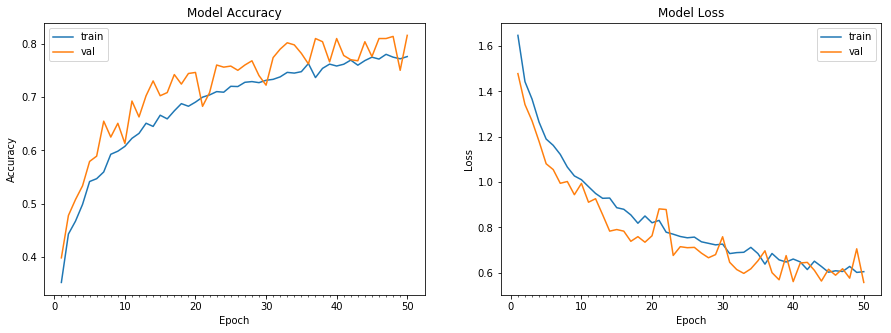

In [125]:
plot_model_history(history)

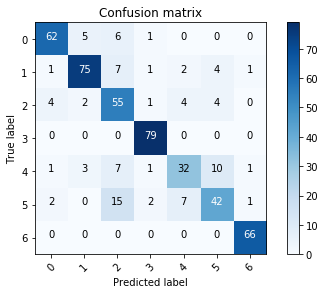

In [126]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0,0.5,'Fraction classified incorrectly')

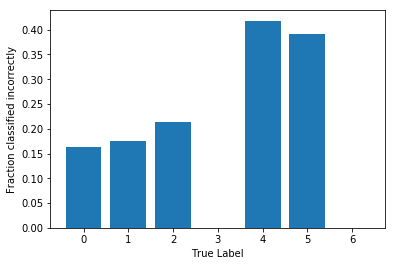

In [127]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [128]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [129]:
epochs = 5 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

NameError: name 'learning_rate_reduction' is not defined